# Lossless Compression

## Imports

In [275]:
from __future__ import division, print_function

from numpy import *
from numpy.random import *

%matplotlib notebook
from matplotlib.pyplot import *

import audio.wave
from audio.bitstream import *
from audio.coders import *

In [276]:
N = 16000 # number of samples

## Unary Coding

In the unary coding scheme, the integer $n$ is encoded as a sequence of $n$ `1` followed by a `0`.

In [277]:
BitStream(7, unary)

11111110

This coding scheme is optimal (it produce the minimum possible average bit length) when applied to a random integer with a geometric distribution with *success probability* $p$ (see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Geometric_distribution)).

In [278]:
help(geometric)

Help on built-in function geometric:

geometric(...)
    geometric(p, size=None)
    
    Draw samples from the geometric distribution.
    
    Bernoulli trials are experiments with one of two outcomes:
    success or failure (an example of such an experiment is flipping
    a coin).  The geometric distribution models the number of trials
    that must be run in order to achieve success.  It is therefore
    supported on the positive integers, ``k = 1, 2, ...``.
    
    The probability mass function of the geometric distribution is
    
    .. math:: f(k) = (1 - p)^{k - 1} p
    
    where `p` is the probability of success of an individual trial.
    
    Parameters
    ----------
    p : float or array_like of floats
        The probability of success of an individual trial.
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  If size is ``None`` (default),
        a single value i

In [279]:
p=1/2
data = geometric(p=p, size=N) - 1
mean(data)

1.0049375

<IPython.core.display.Javascript object>


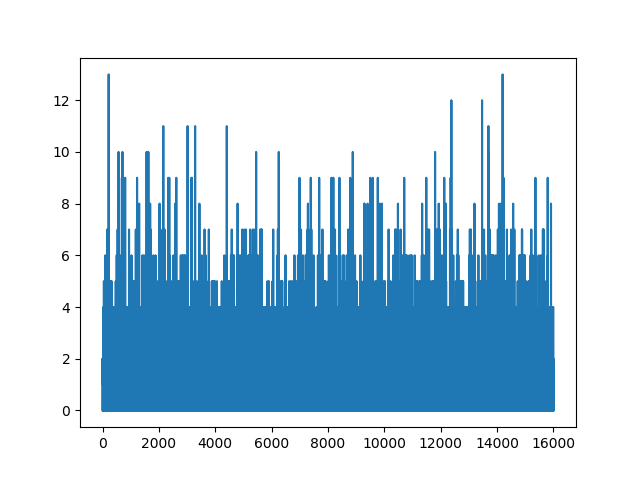

In [280]:
figure()
plot(data)

<IPython.core.display.Javascript object>


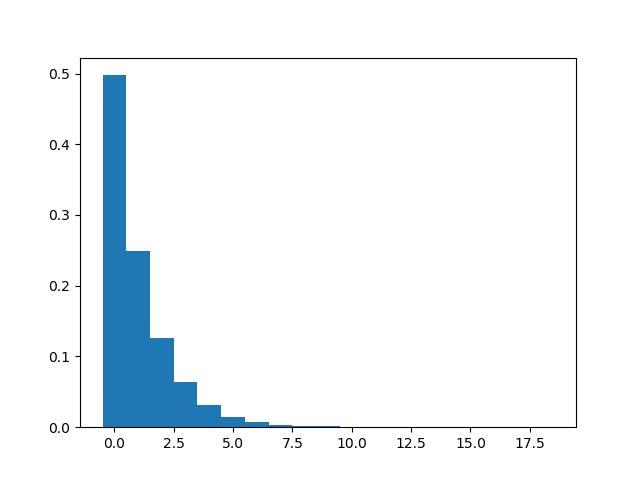

(array([4.976250e-01, 2.496250e-01, 1.266875e-01, 6.437500e-02,
        3.206250e-02, 1.387500e-02, 8.000000e-03, 3.625000e-03,
        1.375000e-03, 1.625000e-03, 5.625000e-04, 3.125000e-04,
        1.250000e-04, 1.250000e-04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Patch objects>)

In [281]:
figure()
hist(data, bins=r_[0:20] - 0.5, density=True)

In [282]:
stream = BitStream(data, unary)
print("average bit length", len(stream) / N)

average bit length 2.0049375


The compression scheme is extremely efficient for integer follow such distributions: only 2 bits are required (in average) to code an integer. But what happens when the integer distribution is "flatter", that is, when the expectation
$m = 1/p - 1$ of the integer increases?

<IPython.core.display.Javascript object>


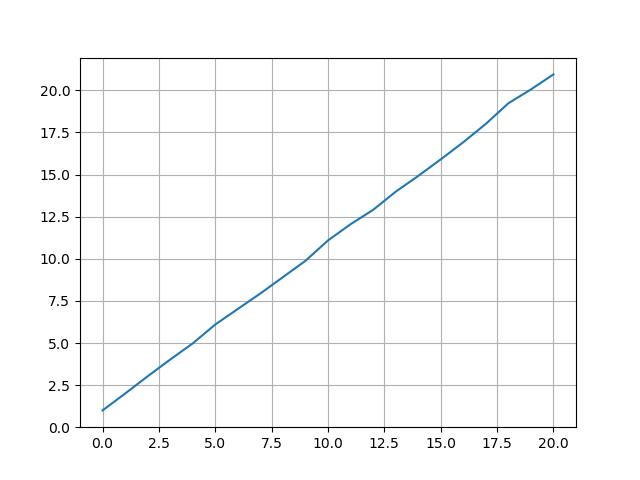

In [283]:
lengths = []
means = range(0, 21)
for mean_ in means:
    p = 1 / (mean_ + 1)
    data = geometric(p=p, size=N) - 1
    stream = BitStream(data, unary)
    lengths.append(len(stream) / N)
figure()
plot(means, lengths)
grid(True)

Ouch. If the mean value of an integer (following a geometric distribution) is 20, 20 bits are required in average with this compression scheme. This is bad, we need to find another coding scheme in the general case. The rice coding scheme,
with $b$ fixed bits may be an alternate: it encodes the $b$ rightmost bits of the binary decomposition of the integer directly, and the bits that may remain on the left using the unary scheme.

In [284]:
b = 4
def rice_coder(datum):
    stream = BitStream()
    global b
    print(bin(datum))
    remain, fixed = divmod(datum, 2 ** b) # quotient and remainder of the division
    print(bin(remain), "|", bin(fixed))
    fixed_bits = []
    for _ in range(b):
        fixed_bits.insert(0, fixed % 2) # insert the last binary digit at the front of the list
        fixed = fixed >> 1 # divide fixed by 2 (integer division)
        print(fixed_bits)
    stream.write(fixed_bits, bool)
    stream.write(remain, unary)
    return stream

In [285]:
good = 0b1011
bad = 0b00101000

In [286]:
rice_coder(good)

0b1011
0b0 | 0b1011
[1]
[1, 1]
[0, 1, 1]
[1, 0, 1, 1]


10110

In [287]:
rice_coder(bad)

0b101000
0b10 | 0b1000
[0]
[0, 0]
[0, 0, 0]
[1, 0, 0, 0]


1000110

Actually, it's easier to use the implementation in audio coders.

In [288]:
BitStream(good, rice(4, signed=False))

10110

In [289]:
BitStream(bad, rice(4, signed=False))

1000110

<IPython.core.display.Javascript object>


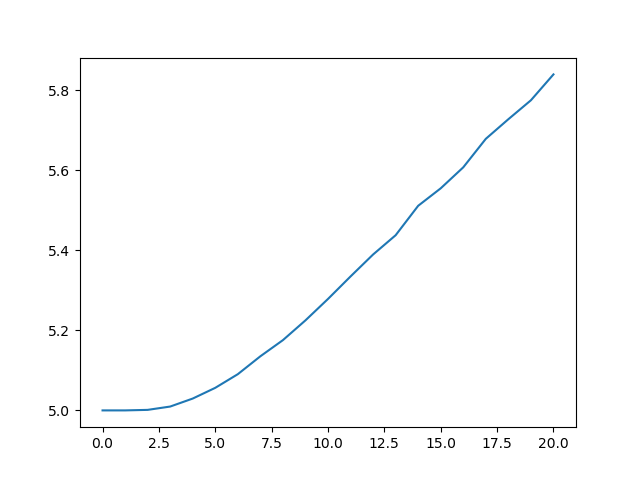

In [290]:
lengths = []
means = range(0, 21)
for mean_ in means:
    p = 1 / (mean_ + 1)
    data = geometric(p=p, size=N) - 1
    rc = rice(4, signed=False)
    stream = BitStream(data, rc)
    lengths.append(len(stream) / N)
figure()
plot(means, lengths)

Better compression than the unary coding, but it can still be improved by (automatically) selecting $b$ as a function of the data: 

rice(b=0, signed=False)
rice(b=0, signed=False)
rice(b=1, signed=False)
rice(b=1, signed=False)
rice(b=2, signed=False)
rice(b=2, signed=False)
rice(b=2, signed=False)
rice(b=2, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=3, signed=False)
rice(b=4, signed=False)
rice(b=4, signed=False)
rice(b=4, signed=False)
rice(b=4, signed=False)


<IPython.core.display.Javascript object>


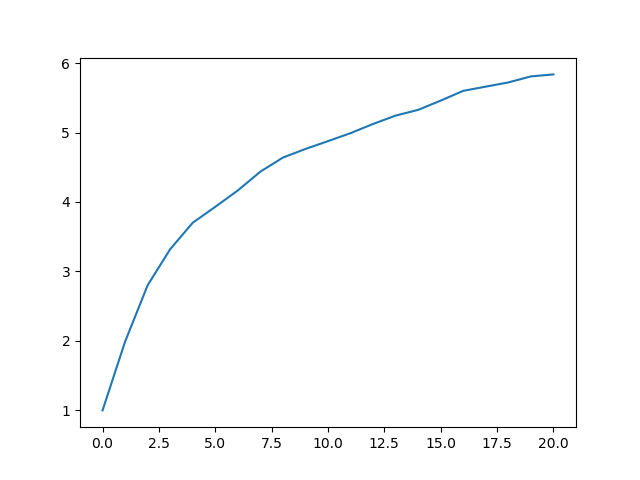

In [291]:
lengths = []
means = range(0, 21)
for mean_ in means:
    p = 1 / (mean_ + 1)
    data = geometric(p=p, size=N) - 1
    rc = rice.from_frame(data, signed=False)
    print(rc)
    stream = BitStream(data, rc)
    lengths.append(len(stream) / N)
figure()
plot(means, lengths)

## Audio (Numeric) Data

In [292]:
f = 440.0
df = 44100.0; dt = 1 / df
t = r_[0:3.0:dt]
data = cos(2*pi*f*t)

In [293]:
help(audio.wave.write)

Help on function write in module audio.wave:

write(data, output=None, df=44100, scale=None)
    Wave Audio File Format Writer
    
    Arguments
    ---------
    
      - `data`: the audio data.
    
        The data should be either a 1-dim. numpy array or a 2-dim numpy 
        array with a dimension of 1 (mono) or 2 (stereo) along the first 
        axis. 
    
      - `output`: a bitstream, filename, file object or `None` (default).
    
        The object where the data is written in the WAVE format.
        An empty bitstream is created if no output is specified.
    
      - `df`: an integer, the sample rate (default: `44100`).
    
      - `scale`: the scaling policy: `None`, `True` or `False`.
    
        This argument determines the linear transformation that scales `data`
        before it is rounded and clipped the to 16-bit integer range.
        The following table displays what value is mapped to `2**15` 
        given `scale` and the type of `data`.
    
    
       

In [294]:
audio.wave.write(data, "A4.wav")
data = audio.wave.read("A4.wav", scale=False)[0] # reload the data AS INTEGERS (don't scale to [-1.0, 1.0])
N = len(data)

<IPython.core.display.Javascript object>


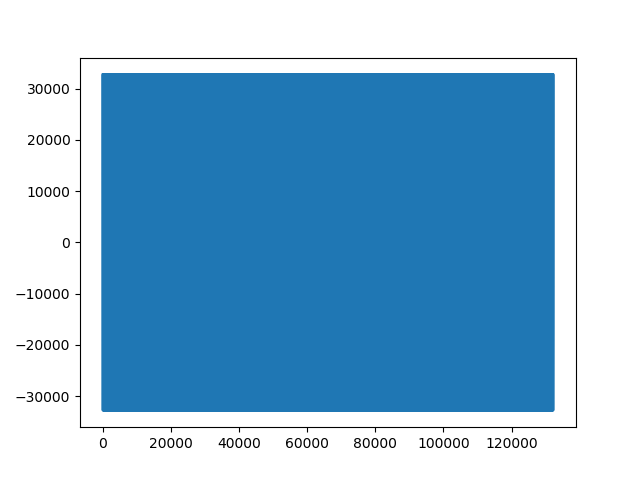

In [295]:
figure()
plot(data)

In [296]:
rc = rice.from_frame(data, signed=True)

In [297]:
rc

rice(b=14, signed=True)

In [298]:
len(BitStream(data, rc)) / N

16.668934240362812

Not good: the average code length is greater than 16 bits. But it's not a surprise since the distribution of values is not at all a geometric distribution. The probability of high values is even larger than the one of low values, a situation than the rice coder is not designed to deal with.

<IPython.core.display.Javascript object>


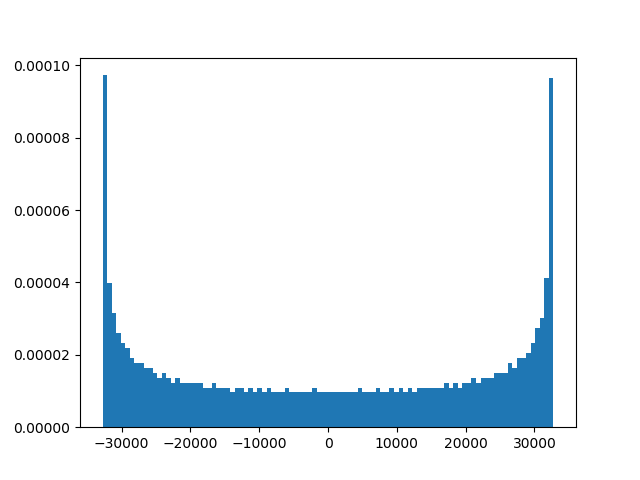

In [299]:
figure()
_ = hist(data, bins=linspace(-2**15-1, 2**15, 100), density=True)

## Differential Rice Coding

We may change this by working with differences between values instead of values directly. For "non-pathological" signals, the range of such values is likely to be smaller than the one of the absolute values. 

In [300]:
data = data.astype(int32) # Achtung ! Beware of the overflow in computations.
len(data)

132300

In [301]:
ddata = diff(r_[0, data]) # make sure that the initial signal value is not lost.
len(ddata)

132300

In [302]:
all(cumsum(ddata) == data) # reconstruct the signal from the differences.

True

In [303]:
rc = rice.from_frame(ddata, signed=True)
len(BitStream(ddata, rc)) / N

12.71769463340892

Smaller than 16 bits. Yes! And that makes sense, since the distribution of the differences is much more compact than the one of the initial values.

<IPython.core.display.Javascript object>


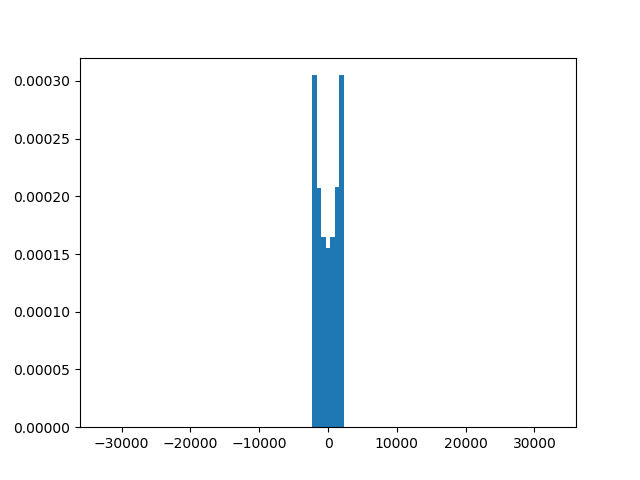

In [304]:
figure()
_ = hist(ddata, bins=linspace(-2**15-1, 2**15, 100), density=True)

High-level differences, localization of the rice coding to frames of say 20 msec, etc. are extra tricks that could improve in general the performance of this compression scheme.